## Setting hardware accelerator to Nvidia

In [7]:
!nvidia-smi

Tue Dec  6 16:29:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 30.9 MB/s 


In [9]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 7.9.0

numpy      : 1.21.6
pandas     : 1.3.5
torch      : 1.12.1+cu113
torchvision: 0.13.1+cu113



# Importing important libraries

In [10]:
import torch, torchvision

In [11]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Downloading the GTSRB dataset

In [12]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2022-12-06 16:29:58--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  13.7MB/s    in 22s     

2022-12-06 16:30:21 (12.2 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



# Exploring the dataset

In [13]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

## Creating Helper functions to load and show images using OpenCV and Torchvision

In [14]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

## Sample of the images in the dataset

<ipython-input-14-d18a9dfb7726>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  images = torch.as_tensor(images)


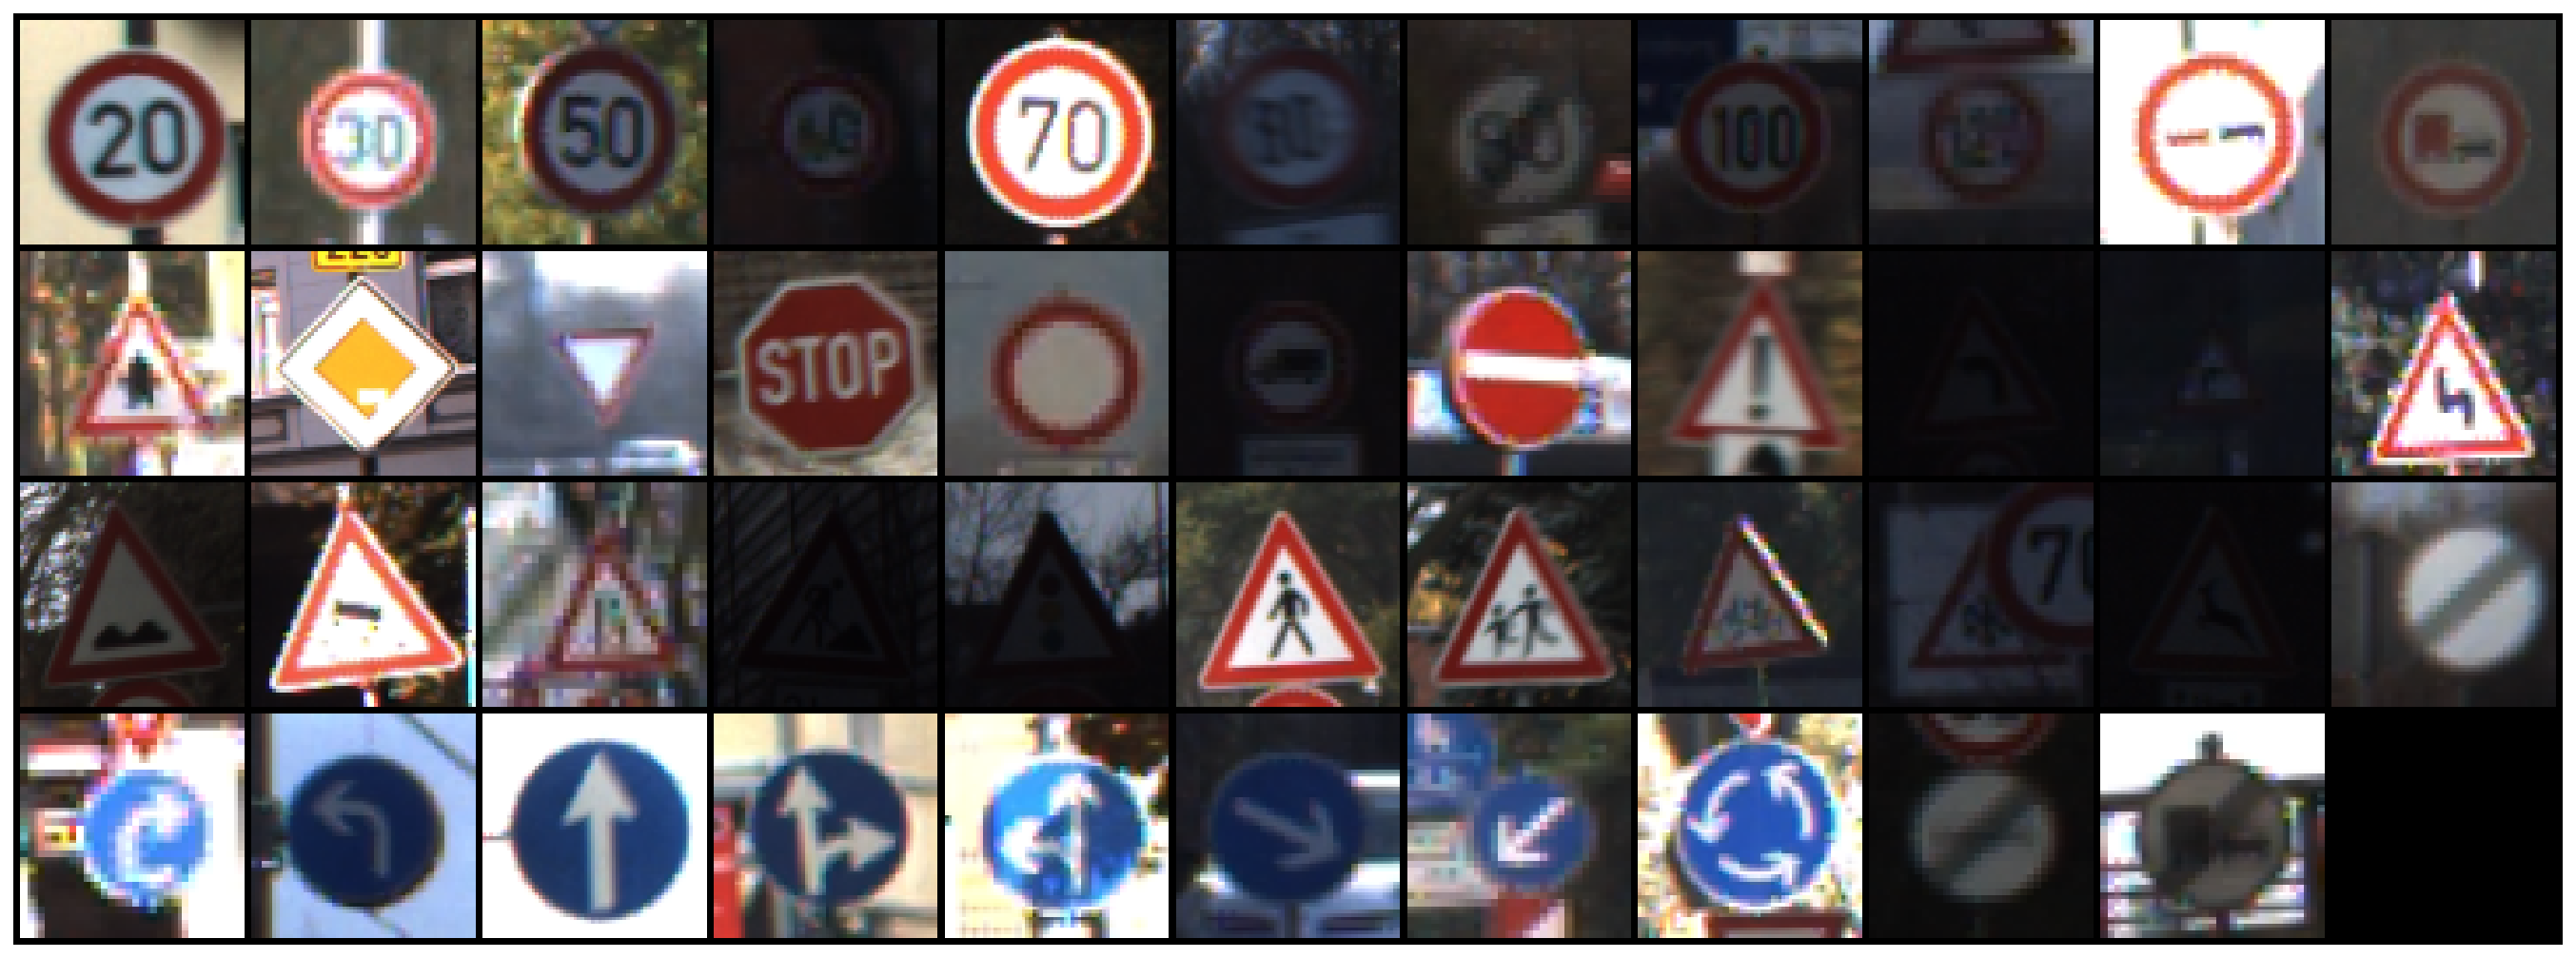

In [15]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

## Random Single Sign

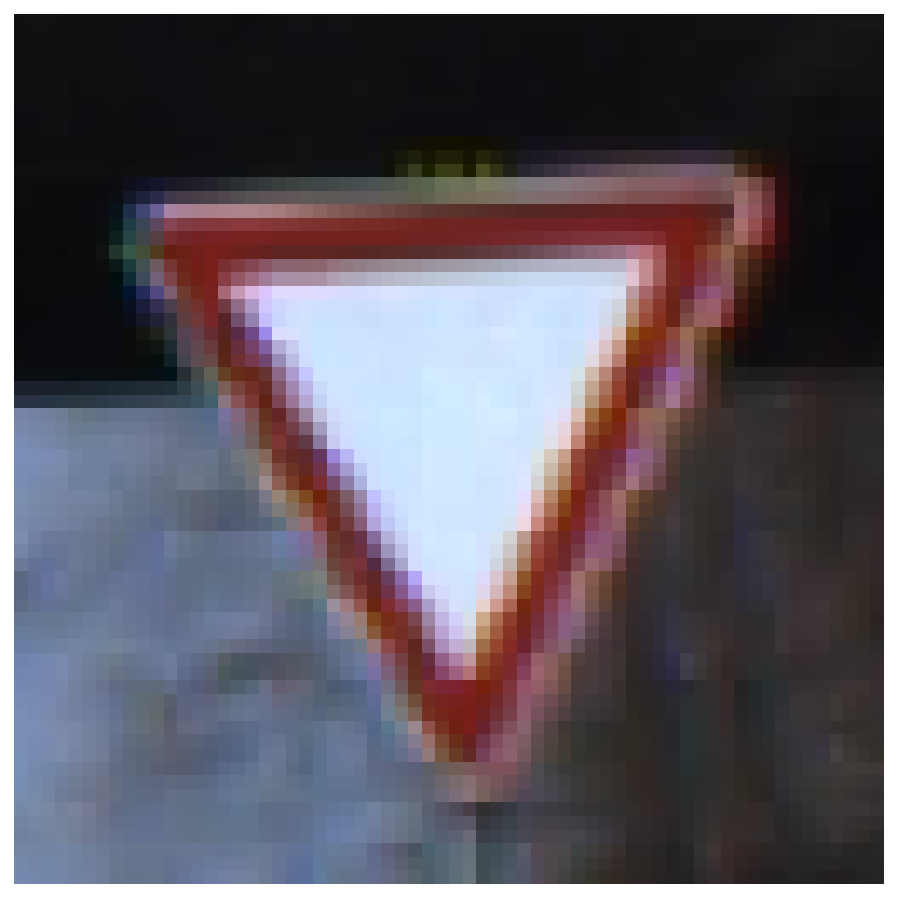

In [16]:
img_path = glob(f'{train_folders[13]}/*ppm')[1]

show_image(img_path)

# Building the dataset

##### We divide the dataset into required signs only, as the following -

In [17]:
class_names = ['30Kmph','50Kmph','60Kmph','70Kmph','80Kmph', 'stop', 'no_entry', 'turn Left','turn right', 'bumpy road']

class_indices = [1, 2, 3, 4, 5, 14, 17, 19, 20, 22]

We will copy images to a new directory, making it easy to use the Torchvision's dataset helpers. 

In [18]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

We'll reserve 80% of the images for training, 10% for validation, and 10% test for each class. We'll copy each image to the correct dataset directory:

In [19]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

30Kmph: 2220
50Kmph: 2250
60Kmph: 1410
70Kmph: 1980
80Kmph: 1860
stop: 780
no_entry: 1110
turn Left: 210
turn right: 360
bumpy road: 390


We have some class imbalance.

We'll apply some image augmentation techniques to artificially increase the size of our training dataset:

In [20]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

We apply some random resizing, rotation, and horizontal flips. Finally, we normalize the tensors using preset values for each channel. This is a [requirement of the pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) in Torchvision.

We'll create a PyTorch dataset for each image dataset folder and data loaders for easier training:

In [21]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We'll also store the number of examples in each dataset and class names for later:

In [22]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 10056, 'val': 1257, 'test': 1257}

some example images with applied transformations. We also need to reverse the normalization and reorder the color channels to get correct image data:

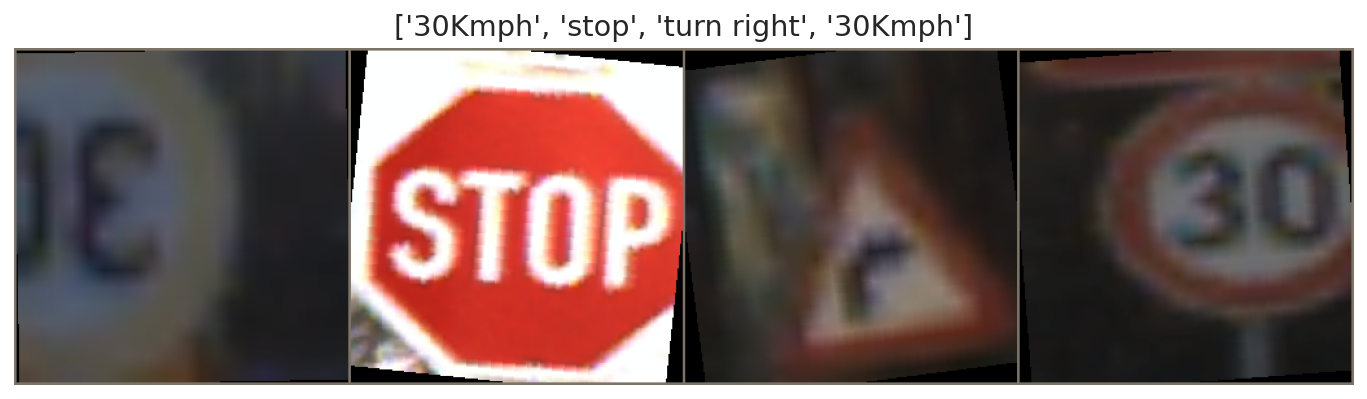

In [23]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Using a pre-trained model:

Our model will receive raw image pixels and try to classify them into one of the traffic signs.

Here, we'll use [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) to copy the architecture of the popular [ResNet](https://arxiv.org/abs/1512.03385) model. On top of that, we'll use the learned weights of the model from training on the [ImageNet dataset ](http://www.image-net.org/).

In [24]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

We reuse almost everything except the change of the output layer. This is needed because the number of classes in our dataset is different than ImageNet.

Instance of the model-

In [25]:
base_model = create_model(len(class_names))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## Training

3 helper functions to encapsulate the training and evaluation logic.

In [26]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

We start by turning our model into train mode and go over the data. After getting the predictions, we get the class with maximum probability along with the loss, so we can calculate the epoch loss and accuracy.

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

Training the model.

In [40]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.20148607975254673 accuracy 0.9246221161495625
Val   loss 0.033369105447531314 accuracy 0.9896579156722355

Epoch 2/3
----------
Train loss 0.2079106529502597 accuracy 0.92233492442323
Val   loss 0.023671320270316407 accuracy 0.9936356404136835

Epoch 3/3
----------
Train loss 0.2045255255438249 accuracy 0.9235282418456643
Val   loss 0.005055889279558963 accuracy 0.9976133651551313

Best val accuracy: 0.9976133651551313
CPU times: user 4min 41s, sys: 11 s, total: 4min 52s
Wall time: 5min 9s


## Evaluation

To check for predictions on random pictures from the dataset

In [41]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

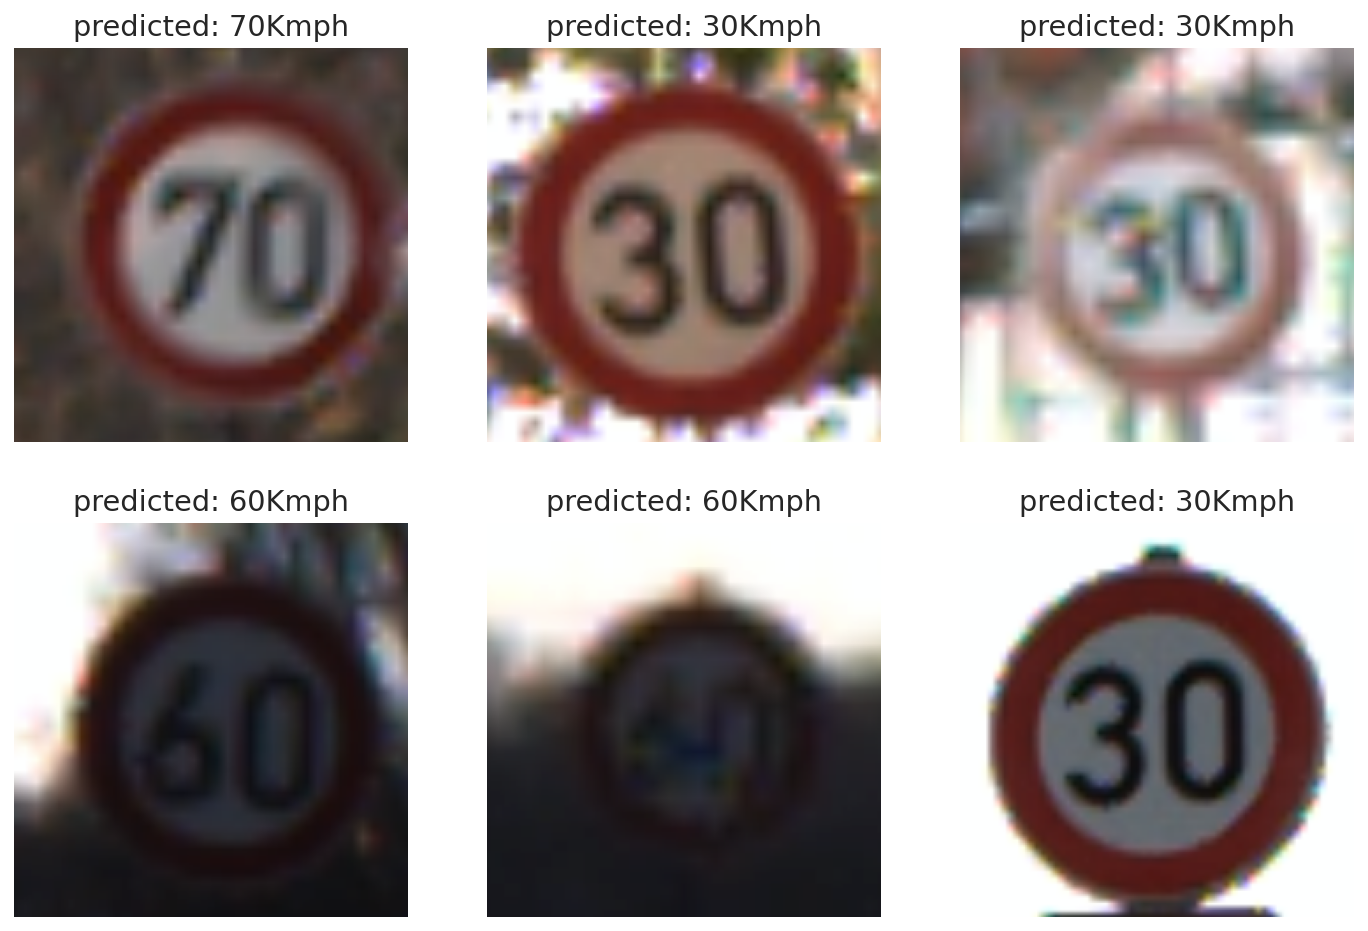

In [43]:
show_predictions(base_model, class_names, n_images=6)

Classifies the signs correctly. However, the predictions are as follows -


In [44]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [45]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [46]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      30Kmph       0.99      1.00      1.00       222
      50Kmph       1.00      1.00      1.00       225
      60Kmph       1.00      0.97      0.99       141
      70Kmph       1.00      0.99      1.00       198
      80Kmph       0.98      0.99      0.99       186
  bumpy road       1.00      1.00      1.00        39
    no_entry       1.00      0.99      1.00       111
        stop       1.00      0.99      0.99        78
   turn Left       0.91      0.95      0.93        21
  turn right       0.95      1.00      0.97        36

    accuracy                           0.99      1257
   macro avg       0.98      0.99      0.99      1257
weighted avg       0.99      0.99      0.99      1257



A confusion matrix plot to see if it makes any mistakes -

In [47]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

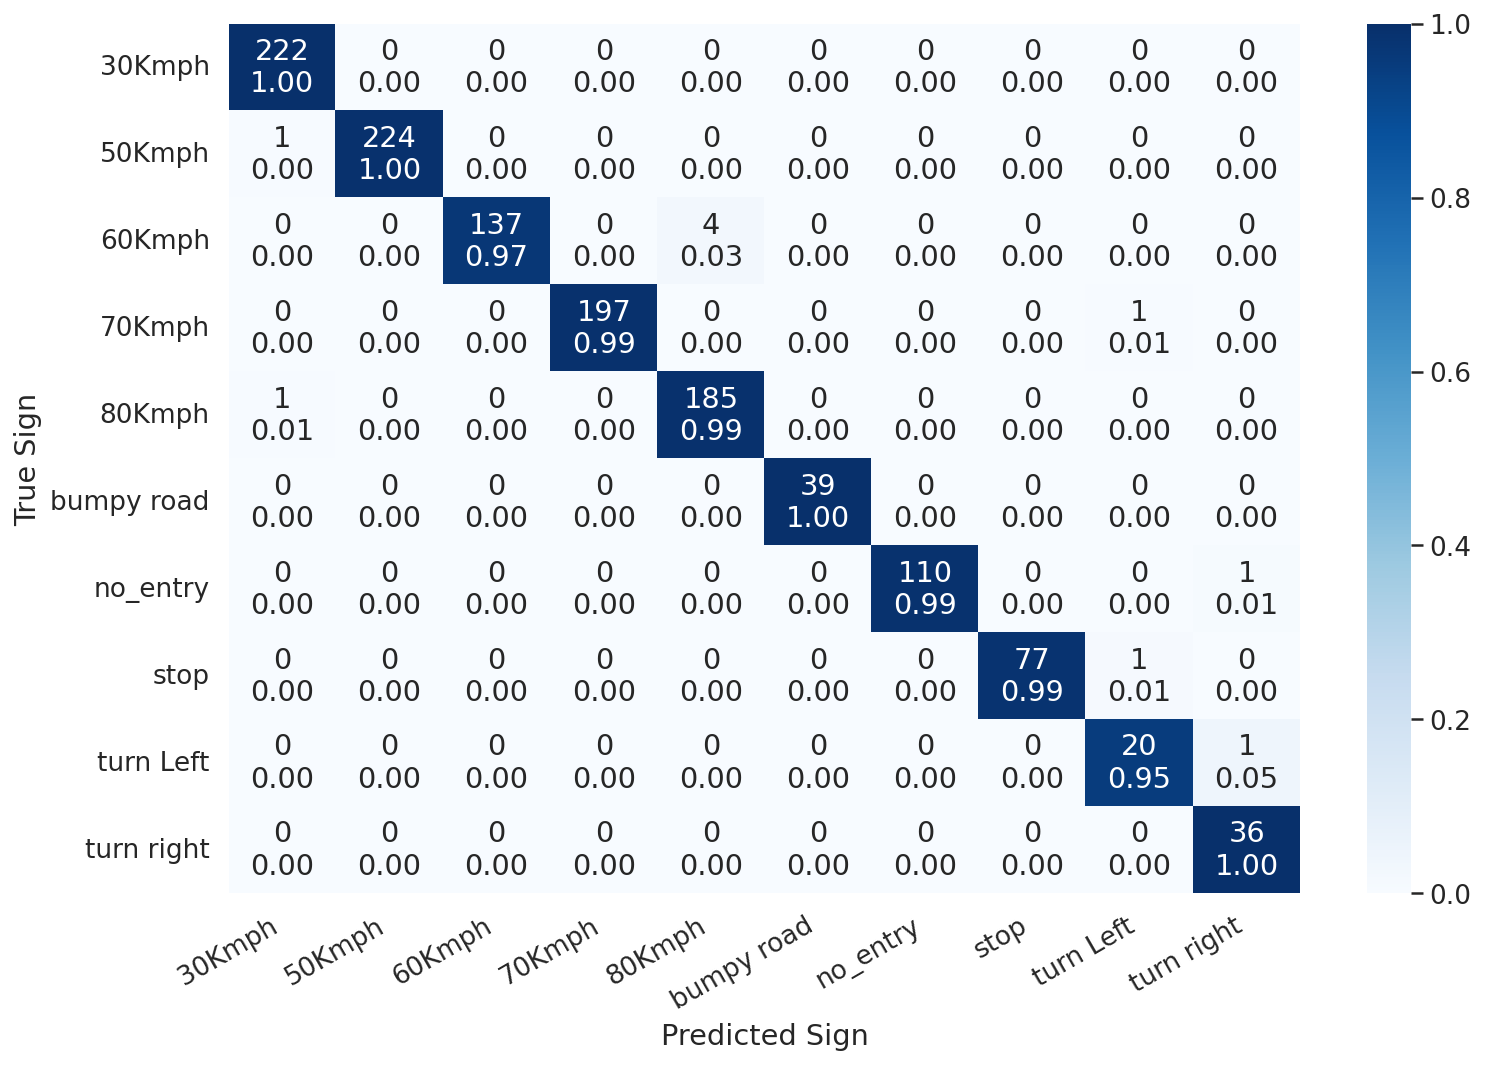

In [48]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

No mistakes that can be noticied.

In [49]:
!gdown --id 1EkN53q9lCO26Z2gWJUeKf2zh_AJw_mRC

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EkN53q9lCO26Z2gWJUeKf2zh_AJw_mRC
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 77.8MB/s]


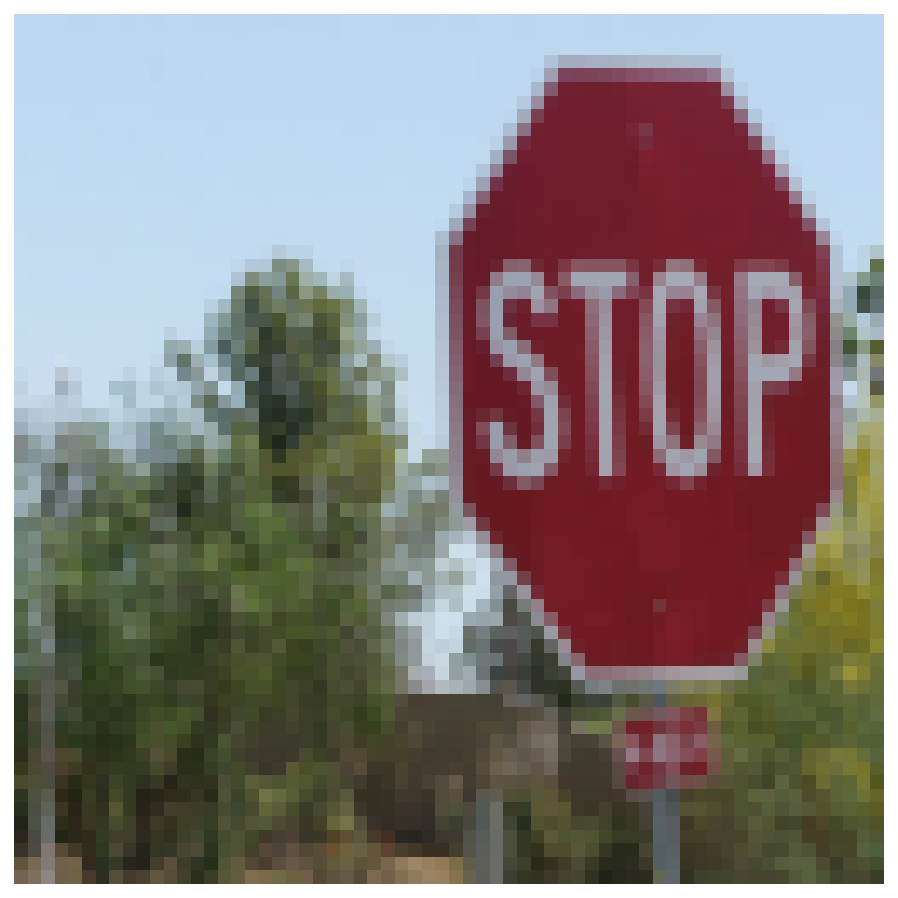

In [50]:
show_image('stop-sign.jpg')

Plotting a confidence plot

In [51]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [52]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([3.1138919e-05, 9.3044539e-05, 1.5363552e-06, 4.6709474e-06,
       1.0124726e-05, 3.4508001e-05, 3.2718928e-04, 9.9947590e-01,
       1.7199500e-05, 4.6450446e-06], dtype=float32)

The above is hard to understand hence it could be easily understood by plotting

In [53]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

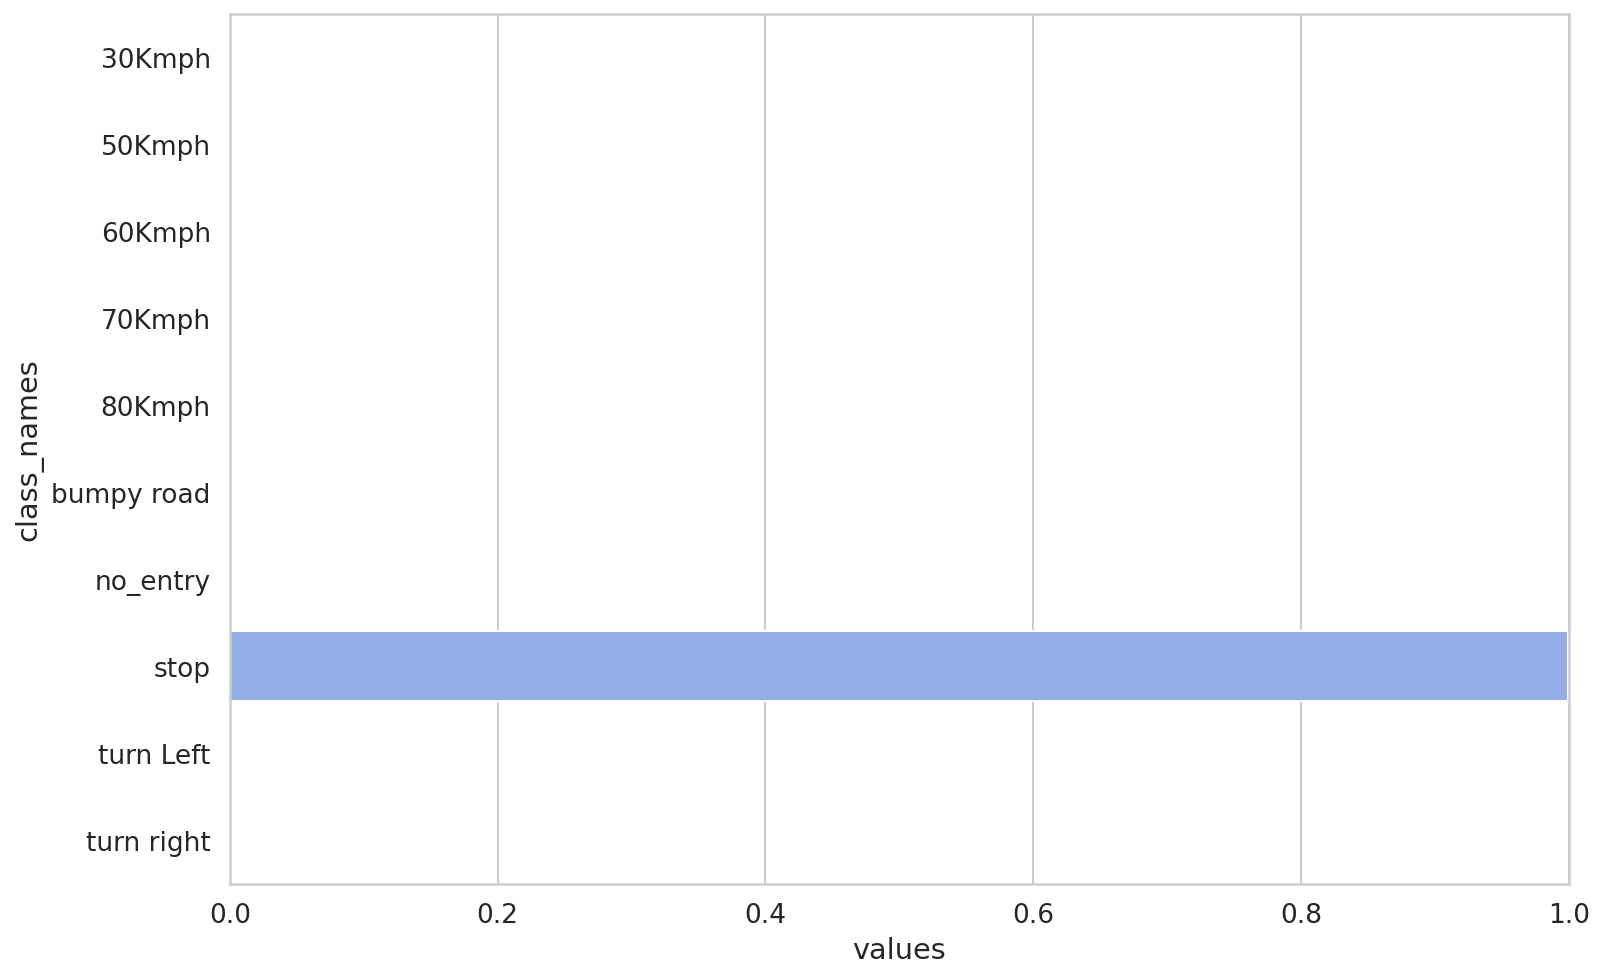

In [54]:
show_prediction_confidence(pred, class_names)

Hence, the model predicts correctly which is indicated by the confidence plot above.

## Classifying Unknown signs

In [55]:
!gdown --id 17XaAyLyrhRAvNztGzPHvi3B27WjfXo8C

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17XaAyLyrhRAvNztGzPHvi3B27WjfXo8C
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 57.2MB/s]


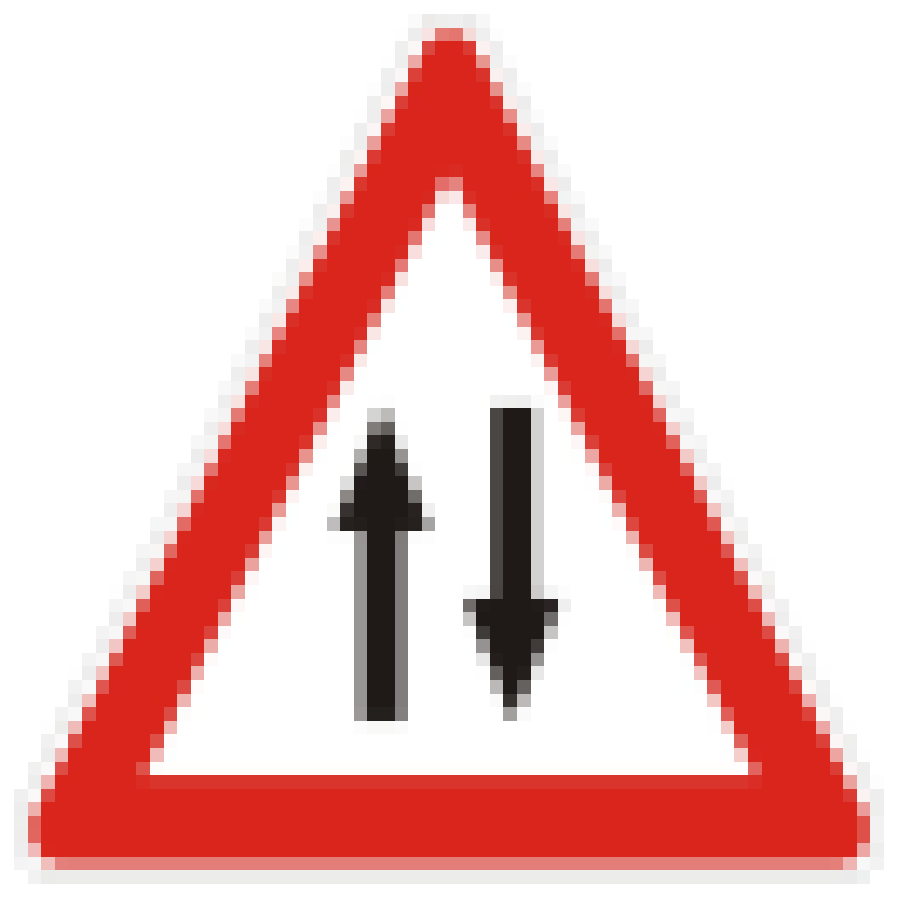

In [56]:
show_image('unknown-sign.jpg')

Getting the prediction

In [57]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

array([7.1544877e-05, 9.1380665e-05, 7.2586172e-06, 5.1540963e-04,
       1.0566792e-04, 9.8386139e-01, 9.8345321e-05, 9.0690683e-06,
       1.3292766e-02, 1.9471911e-03], dtype=float32)

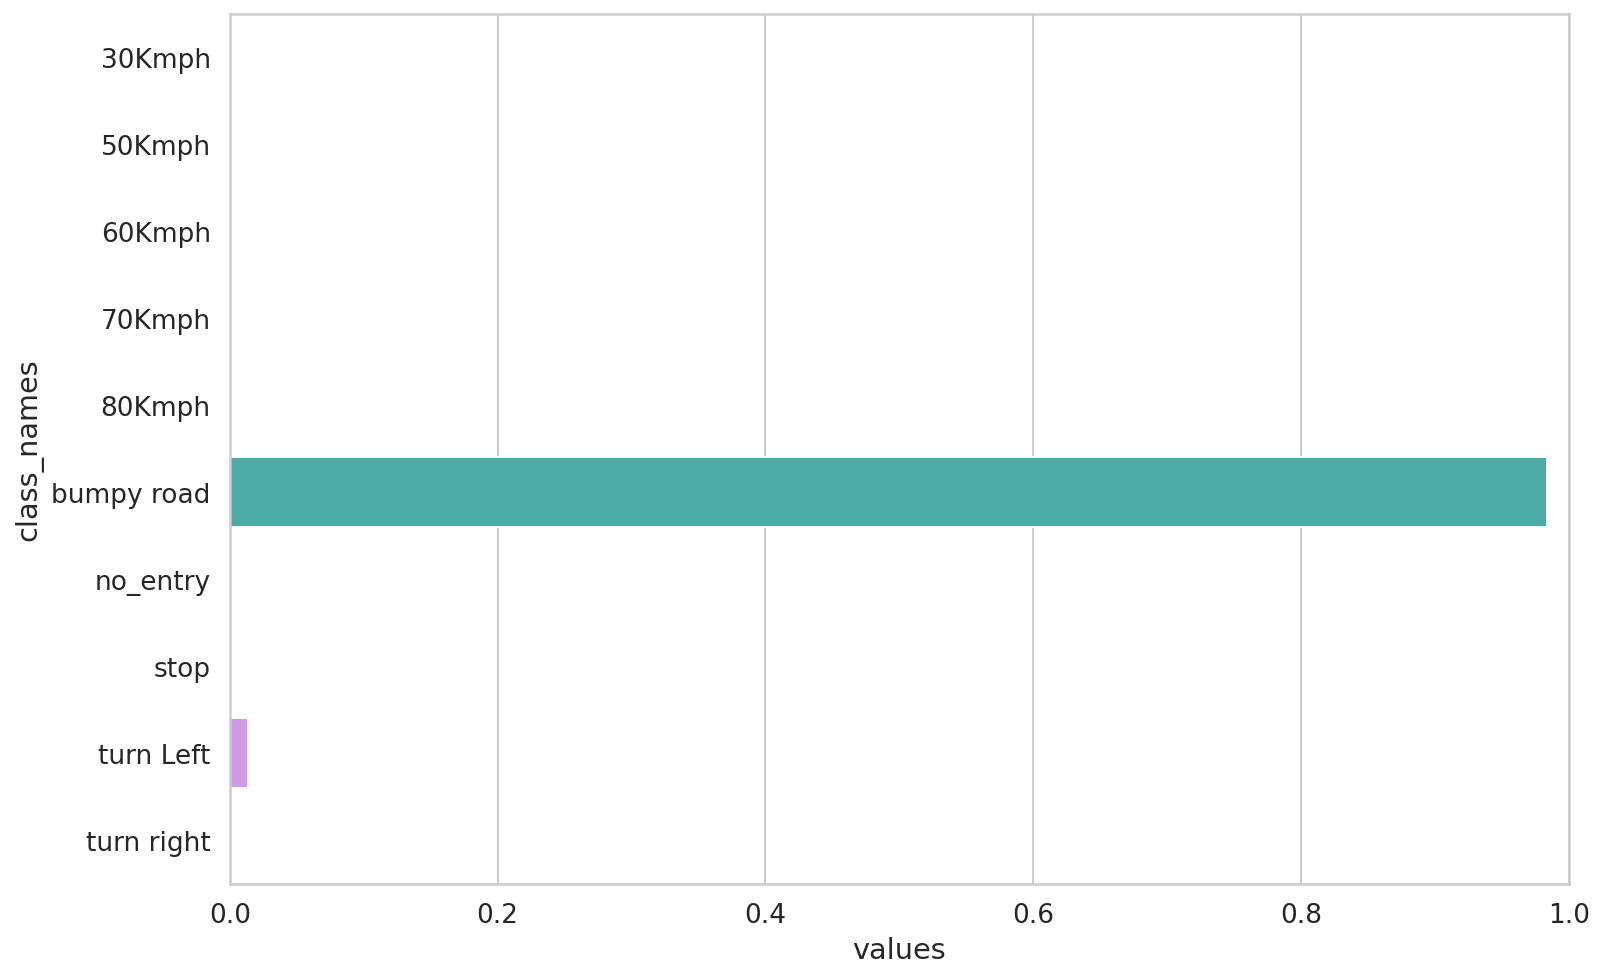

In [58]:
show_prediction_confidence(pred, class_names)

The model is confidently predicting it as bumpy road while its  really not

# Adding an Unknown Class

We can do so by getting the indices of all the classes of signs in our original dataset.

In [59]:
unknown_indices = [
  i for i, f in enumerate(train_folders) \
  if i not in class_indices
]

len(unknown_indices)

33

We create a folder and copy some of the data into that folder.

In [60]:
for ds in DATASETS:
  (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)

for ui in unknown_indices:
  image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
  image_paths = np.random.choice(image_paths, 50)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')

Like we did earlier 

In [61]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'train': 10756, 'val': 1403, 'test': 1400}

In [62]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3
----------
Train loss 0.8439306935792295 accuracy 0.7261063592413536
Val   loss 0.16458314339008387 accuracy 0.9444048467569495

Epoch 2/3
----------
Train loss 0.41535937815411766 accuracy 0.8625883227965786
Val   loss 0.10058919766344196 accuracy 0.9714896650035638

Epoch 3/3
----------
Train loss 0.35862883853657856 accuracy 0.8790442543696542
Val   loss 0.0717401045647944 accuracy 0.9757662152530293

Best val accuracy: 0.9757662152530293
CPU times: user 5min 3s, sys: 12.6 s, total: 5min 16s
Wall time: 5min 28s


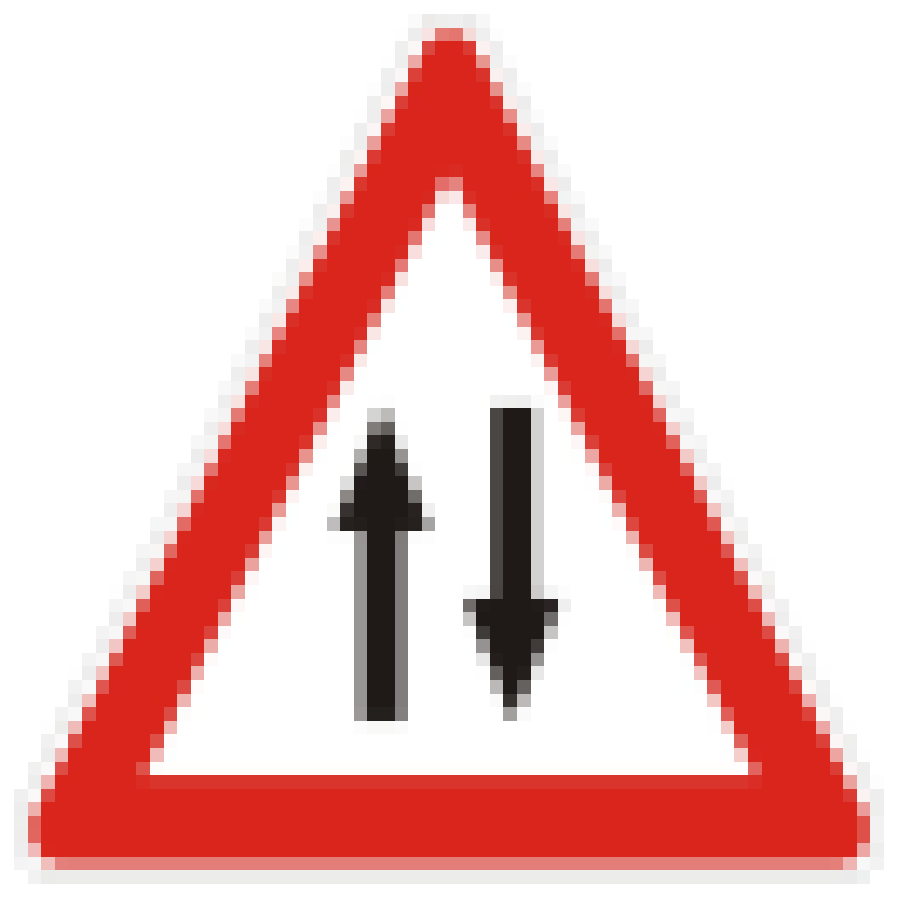

In [63]:
show_image('unknown-sign.jpg')

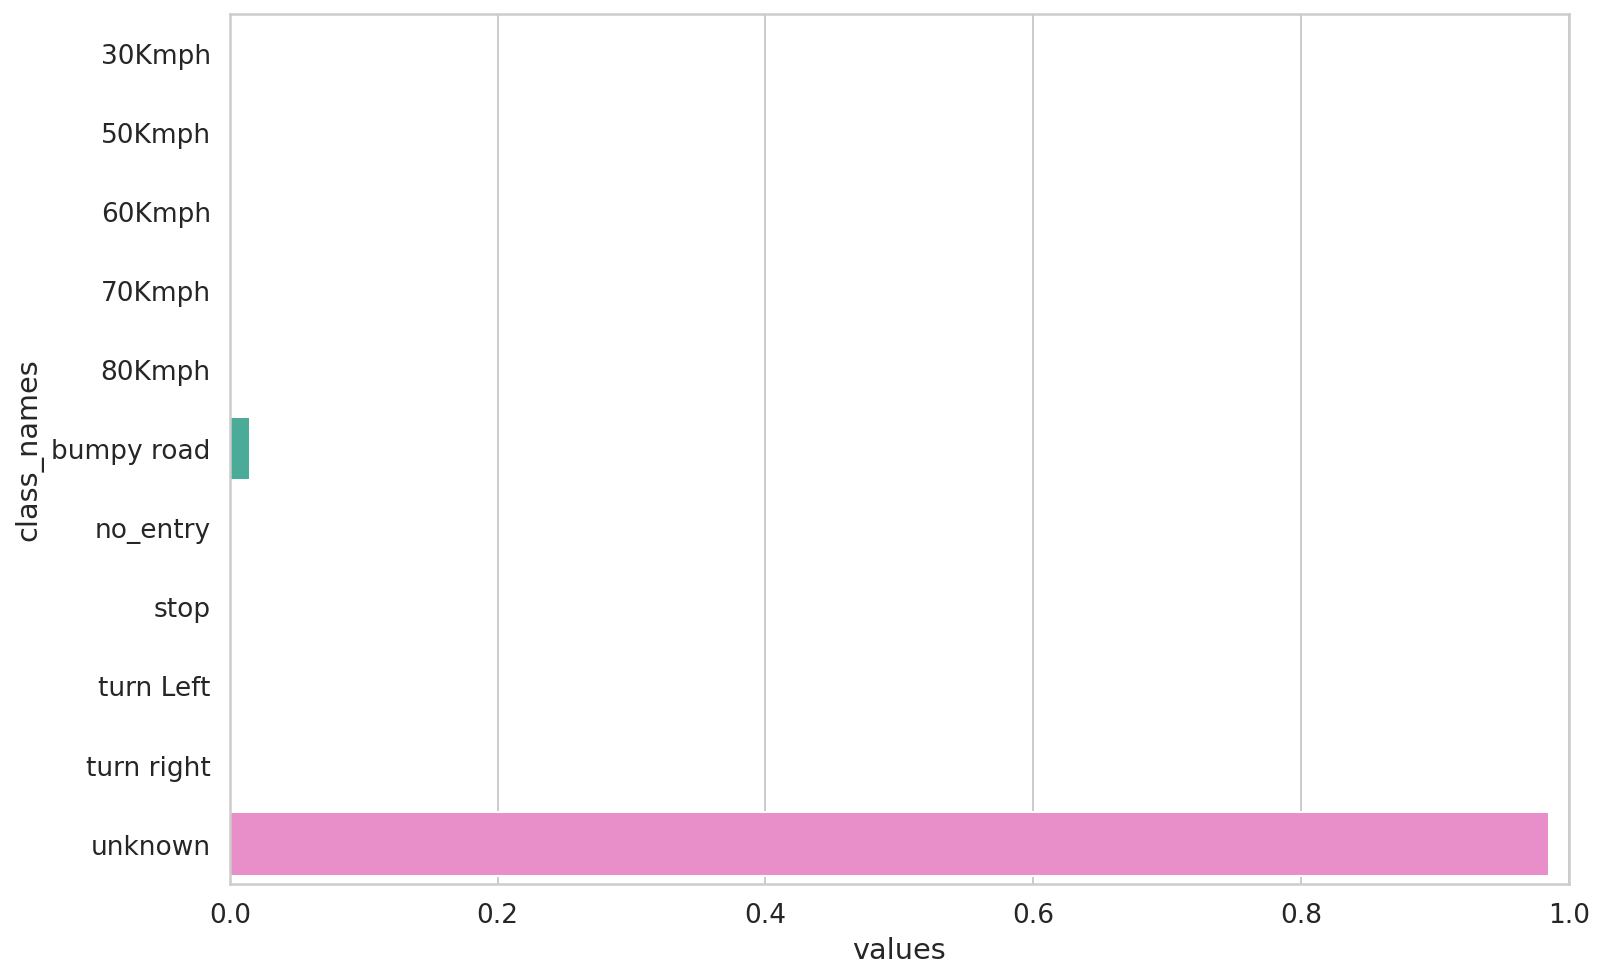

In [64]:
pred = predict_proba(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

the model doesn't give much weight to any of the known classes. It doesn't know that this is a two-way sign, but recognizes is as unknown.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


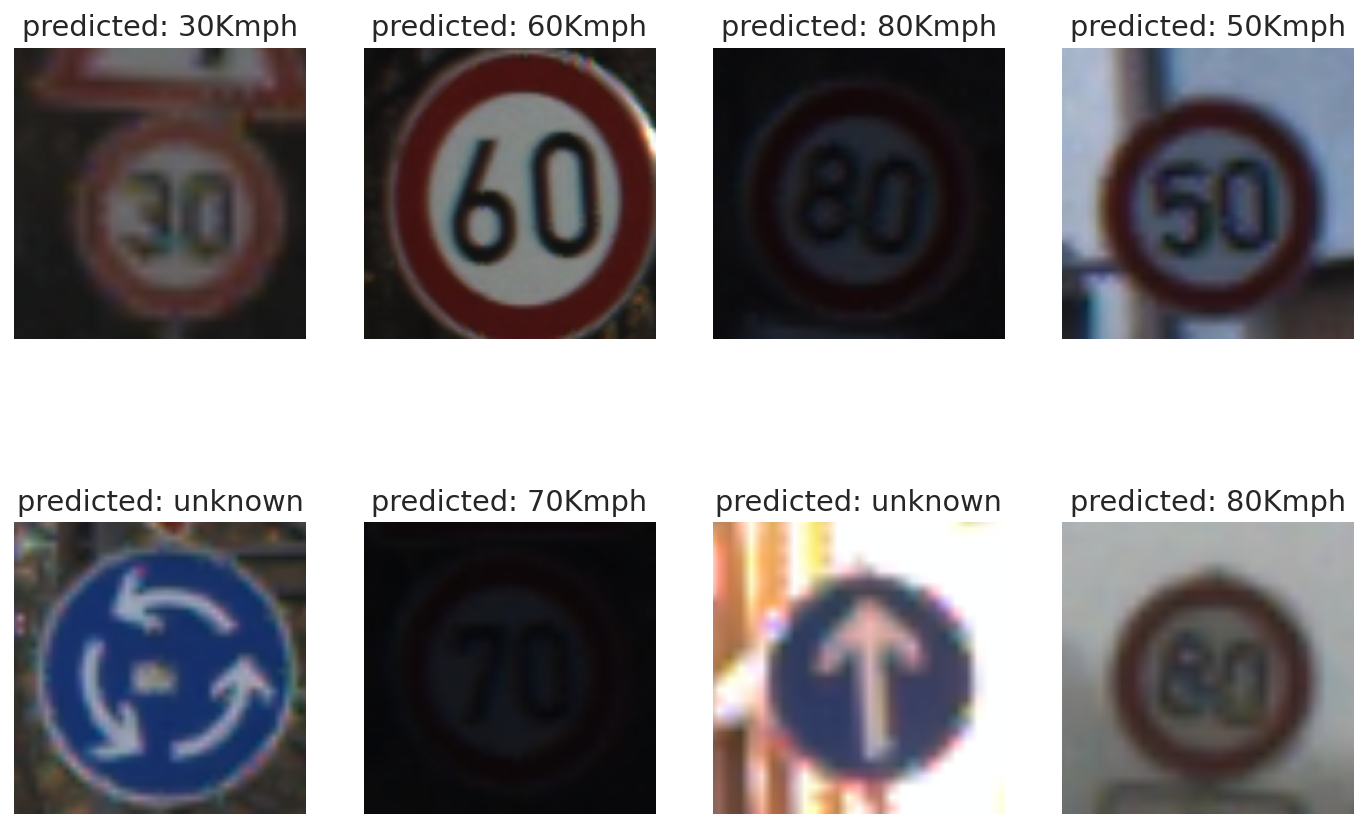

In [65]:
show_predictions(enchanced_model, class_names, n_images=8)

Performance of the new model

In [66]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

In [67]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      30Kmph       1.00      1.00      1.00       222
      50Kmph       1.00      0.97      0.99       225
      60Kmph       1.00      0.99      1.00       141
      70Kmph       0.99      0.98      0.99       198
      80Kmph       0.95      1.00      0.98       186
  bumpy road       0.97      1.00      0.99        39
    no_entry       0.99      1.00      1.00       111
        stop       1.00      0.99      0.99        78
   turn Left       0.74      0.81      0.77        21
  turn right       0.80      0.89      0.84        36
     unknown       0.97      0.94      0.95       143

    accuracy                           0.98      1400
   macro avg       0.95      0.96      0.95      1400
weighted avg       0.98      0.98      0.98      1400



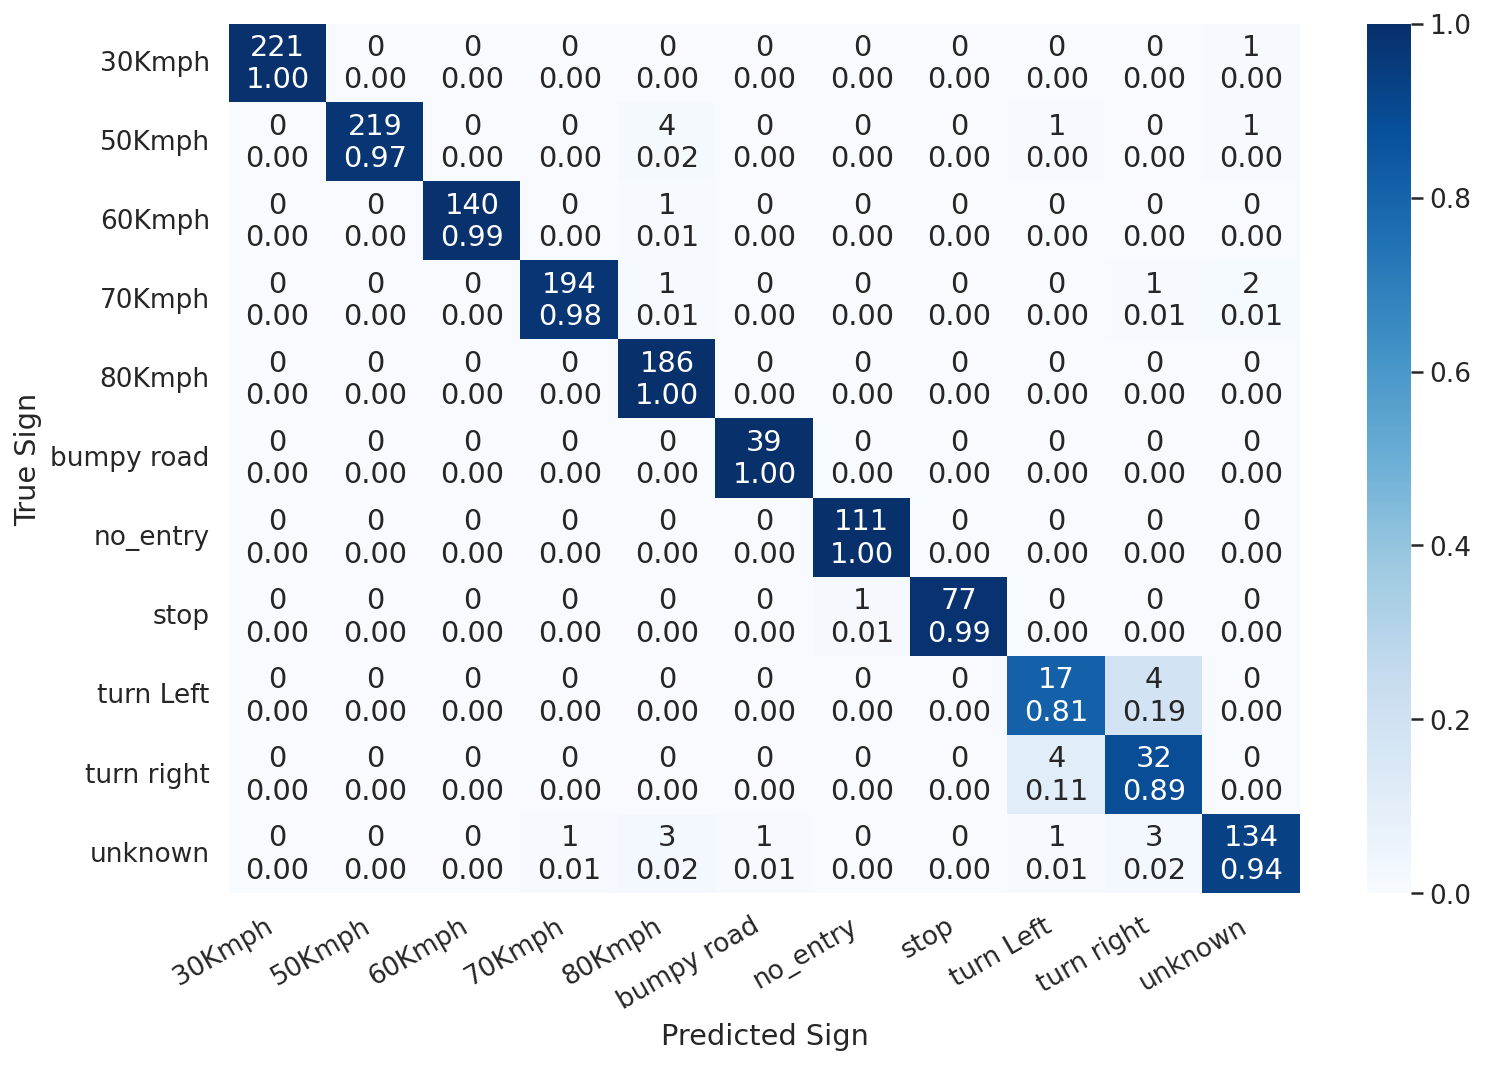

In [68]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

# Conclusion

2 models are built using the trasnfer learning based on Resnet-34, by building a dataset that is compatible with torchvision.

 - The first model could predict signs with a greater accruacy but couldn't classify the unknown ones.
 - The second model was made to have a class known as unknown, hence predicting the wrong signs as unknown.